In [29]:
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

class DecisionTree:
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _calculate_gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _find_best_split(self, X, y, sample_weights):
        n_samples, n_features = X.shape
        current_gini = self._calculate_gini(y)
        best_gini = 1.0
        best_split = None

        for feature_index in range(n_features):
            unique_values = np.unique(X[:, feature_index])
            for threshold in unique_values:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue

                left_gini = self._calculate_gini(y[left_indices])
                right_gini = self._calculate_gini(y[right_indices])
                weighted_gini = (left_gini * len(left_indices) + right_gini * len(right_indices)) / n_samples

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = (feature_index, threshold, left_indices, right_indices)

        return best_split

    
    def _build_tree(self, X, y, sample_weights, depth=0):
        n_samples, n_features = X.shape
        unique_classes, counts = np.unique(y, return_counts=True)
        predicted_class = unique_classes[np.argmax(counts)]

        if len(unique_classes) == 1:
            return predicted_class

        if self.max_depth is not None and depth == self.max_depth:
            return predicted_class
        if len(y) < self.min_samples_split:
            return predicted_class

        best_split = self._find_best_split(X, y, sample_weights)
        if best_split is None:
            return predicted_class

        feature_index, threshold, left_indices, right_indices = best_split
        left_subtree = self._build_tree(X[left_indices], y[left_indices], sample_weights[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], sample_weights[right_indices], depth + 1)

        return feature_index, threshold, left_subtree, right_subtree

    def _create_leaf_node(self, y, sample_weights):
        if len(y) == 0:
            raise ValueError("Empty node encountered.")
        class_weights = np.bincount(y, weights=sample_weights)
        most_common_class = np.argmax(class_weights)
        return most_common_class

    def fit(self, X, y, sample_weights=None):
        if sample_weights is None:
            sample_weights = np.ones(len(y)) / len(y)
        else:
            sample_weights = np.squeeze(sample_weights)  
        if len(sample_weights) != len(y):
            raise ValueError("Dimensions of sample_weights and y do not match.")

        self.tree = self._build_tree(X, y, sample_weights)

        
    def predict(self, X):
        predictions = [self._predict_sample(sample, self.tree) for sample in X]
        return np.array(predictions)

    def _predict_sample(self, sample, node):
        if isinstance(node, np.int64):
            return node
        feature_index, threshold, left_subtree, right_subtree = node
        if sample[feature_index] <= threshold:
            return self._predict_sample(sample, left_subtree)
        else:
            return self._predict_sample(sample, right_subtree)

        


In [30]:
class RandomForest:
    def __init__(self, classifier, num_trees, min_features, max_depth=None):
        self.classifier = classifier
        self.num_trees = num_trees
        self.min_features = min_features
        self.max_depth = max_depth
        self.forest = []

    def fit(self, X, y):
        num_samples, num_features = X.shape
        if self.min_features > num_features:
            raise ValueError("min_features should be less than or equal to the number of features")
        
        for _ in range(self.num_trees):
            sample_indices = np.random.choice(num_samples, num_samples, replace=True)
            num_features_to_use = np.random.randint(self.min_features, num_features + 1)
            feature_indices = np.random.choice(num_features, num_features_to_use, replace=False)
            sampled_X = X[sample_indices][:, feature_indices]
            sampled_y = y[sample_indices]

            tree = self.classifier(max_depth=self.max_depth)
            tree.fit(sampled_X, sampled_y)
            self.forest.append((tree, feature_indices))

    def predict(self, X):
        all_predictions = np.zeros((self.num_trees, X.shape[0]))
        for i, (tree, feature_indices) in enumerate(self.forest):
            sampled_X = X[:, feature_indices]
            all_predictions[i] = tree.predict(sampled_X)
        
        final_predictions = np.round(np.mean(all_predictions, axis=0))
        return final_predictions

        


In [31]:

class AdaBoost:
    def __init__(self, weak_learner, num_learners, learning_rate=1.0):
        self.weak_learner = weak_learner
        self.num_learners = num_learners
        self.learning_rate = learning_rate
        self.alphas = []  
        self.models = []  

    def fit(self, X, y):
        num_samples = len(y)
        sample_weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_learners):
            weak_learner = self.weak_learner()
            weak_learner.fit(X, y, sample_weights)
            predictions = weak_learner.predict(X)

            weighted_error = np.sum(sample_weights * (predictions != y))

            if weighted_error == 0:
                weighted_error = 1e-10

            alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
            self.alphas.append(alpha)
            self.models.append(weak_learner)

            exponential_term = -alpha * y * predictions
            sample_weights *= np.exp(exponential_term)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for learner, alpha in zip(self.models, self.alphas):
            predictions += alpha * learner.predict(X)
        return np.sign(predictions)




In [32]:

data = pd.read_csv("4train.csv")


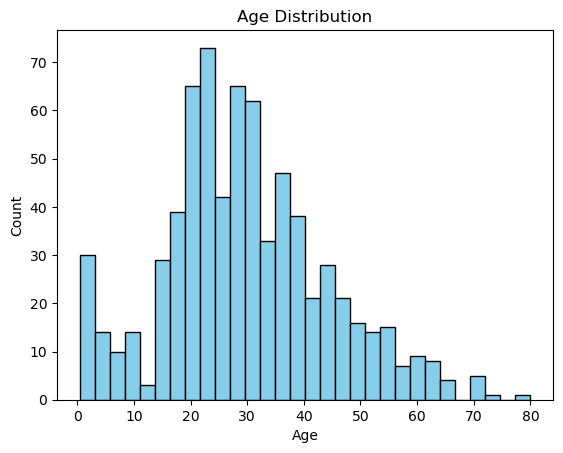

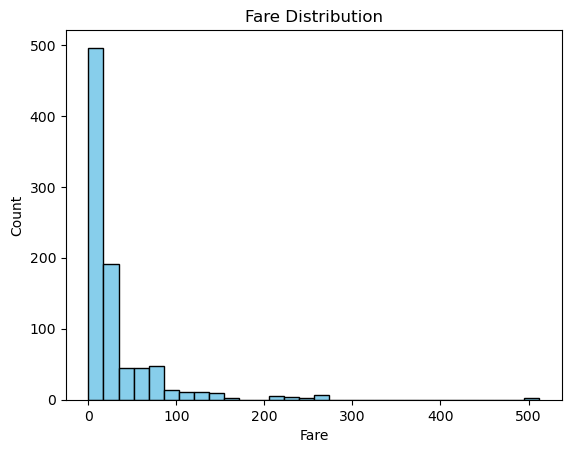

In [33]:
import matplotlib.pyplot as plt

plt.hist(data['Age'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

plt.hist(data['Fare'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Fare Distribution')
plt.show()


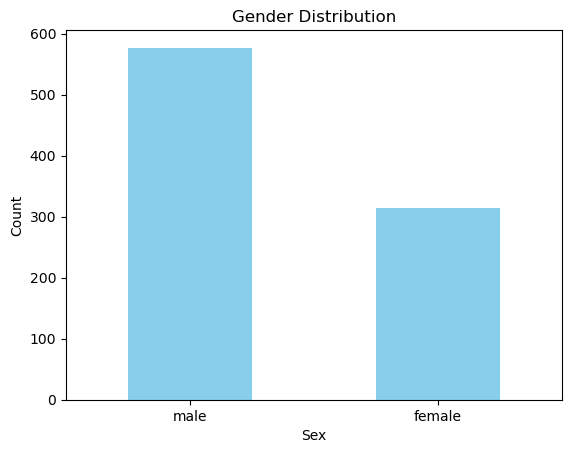

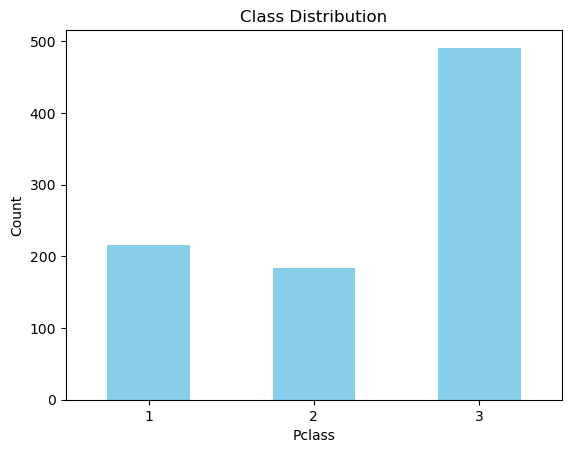

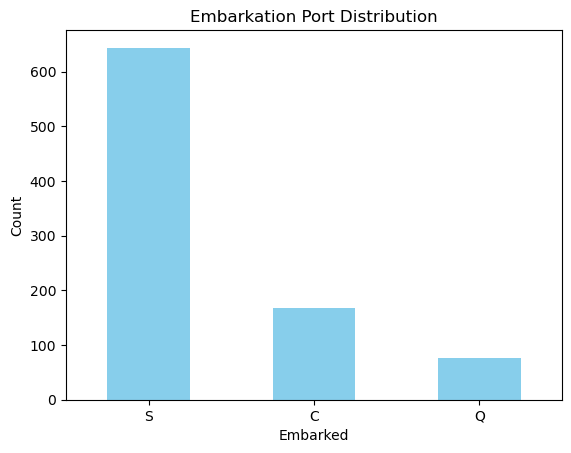

In [34]:
data['Sex'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.xticks(rotation=0)
plt.show()

data['Pclass'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

data['Embarked'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Embarkation Port Distribution')
plt.xticks(rotation=0)
plt.show()


/var/folders/48/hmsj0mgs269c6b1nbsc_pxpc0000gn/T/ipykernel_3365/466239194.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


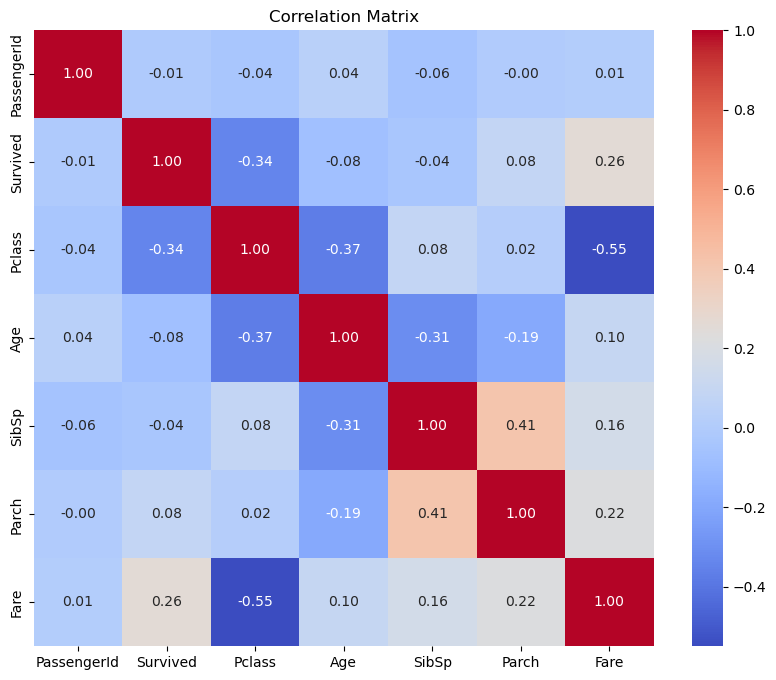

In [35]:
import seaborn as sns

correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


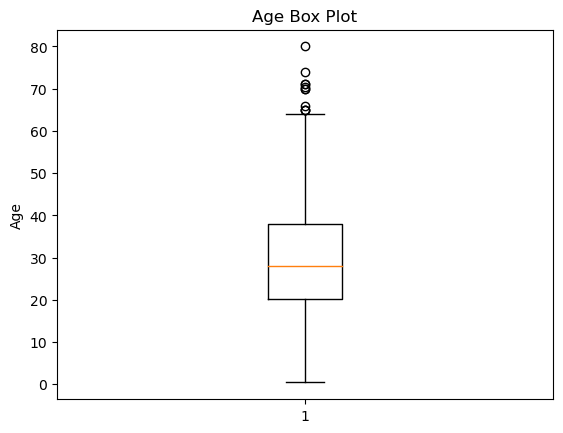

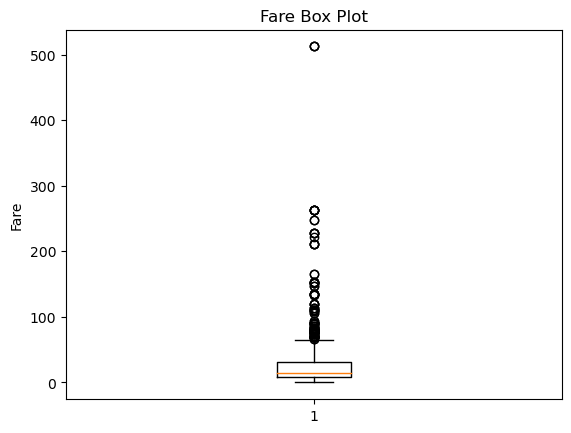

In [36]:
plt.boxplot(data['Age'].dropna())
plt.ylabel('Age')
plt.title('Age Box Plot')
plt.show()

plt.boxplot(data['Fare'])
plt.ylabel('Fare')
plt.title('Fare Box Plot')
plt.show()


In [37]:
columns_to_drop = ['Name', 'Ticket', 'Cabin']
for col in columns_to_drop:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[features]
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = {}


In [43]:
# Decision Tree Classifier
dt_classifier = DecisionTree(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=1)
dt_classifier.fit(X_train.values, y_train.values)
dt_predictions = dt_classifier.predict(X_test.values)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_roc_auc = roc_auc_score(y_test, dt_predictions)  # Calculate ROC-AUC score
results['Decision Tree'] = {'Accuracy': dt_accuracy, 'ROC-AUC': dt_roc_auc}



ab_classifier = AdaBoost(weak_learner=DecisionTree, num_learners=100, learning_rate=1.0)
ab_classifier.fit(X_train.values, y_train.values)
ab_predictions = ab_classifier.predict(X_test.values)
ab_accuracy = accuracy_score(y_test, ab_predictions)
ab_roc_auc = roc_auc_score(y_test, ab_predictions)  # Calculate ROC-AUC score

results['AdaBoost'] = {'Accuracy': ab_accuracy, 'ROC-AUC': ab_roc_auc}
rf_classifier = RandomForest(classifier=DecisionTree, num_trees=100, min_features=3, max_depth=5)
rf_classifier.fit(X_train.values, y_train.values)
rf_predictions = rf_classifier.predict(X_test.values)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)  # Calculate ROC-AUC score

results['Random Forest'] = {'Accuracy': rf_accuracy, 'ROC-AUC': rf_roc_auc}


results_df = pd.DataFrame(list(results.items()), columns=['Classifier', 'Accuracy'])




results_df = pd.DataFrame(results).T  # Transpose to have models as rows and metrics as columns

# Display the DataFrame
print("Results:")
print(results_df)


Results:
               Accuracy   ROC-AUC
Decision Tree  0.798883  0.776705
AdaBoost       0.748603  0.745817
Random Forest  0.798883  0.778700
